In [1]:
%matplotlib inline

In [19]:
import numpy as np
import pandas as pd
from scipy.stats import gmean

In [3]:
import matplotlib.pyplot as plt

In [4]:
import config
from utils.io import load_pickle
from utils.torch.datasets import PathologicalImagesDataset, PathologicalImagesDatasetMode
from utils.scoring import topcoder_metric
from predict import get_prediction_filename

# Load dataset

In [96]:
nb_folds = 5
fold_number = 3
models = ['unet', 'tiramisu', 'unet_ds'] # ['unet', 'tiramisu', 'unet_ds']
patch_size_train = 0
patch_size_predict = 0
use_dice = False
use_tta = False

In [97]:
threshold = 0.4

In [98]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR

In [99]:
dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)

In [100]:
images = [dataset[i][0] for i in range(len(dataset))]
masks = [dataset[i][1] for i in range(len(dataset))]

In [101]:
images = np.stack(images)
masks = np.stack(masks)

In [102]:
images.shape, masks.shape

((33, 500, 500, 3), (33, 500, 500))

# Load predictions 

In [103]:
predictions = []
for model in models:
    filename = get_prediction_filename(model, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
    _, model_predictions = load_pickle(filename)
    
    predictions.append(model_predictions)

In [104]:
[p.shape for p in predictions]

[(33, 500, 500), (33, 500, 500), (33, 500, 500)]

In [105]:
# add mean predictions
predictions.append(gmean(predictions, axis=0))
models.append('gmean')

predictions.append(np.mean(predictions, axis=0))
models.append('mean')

In [106]:
[p.shape for p in predictions]

[(33, 500, 500),
 (33, 500, 500),
 (33, 500, 500),
 (33, 500, 500),
 (33, 500, 500)]

In [107]:
predictions_masks = []
for model_predictions in predictions:
    model_predictions_mask = np.zeros_like(model_predictions)
    model_predictions_mask[model_predictions>threshold] = 1
    
    predictions_masks.append(model_predictions_mask)

# Plot predictions

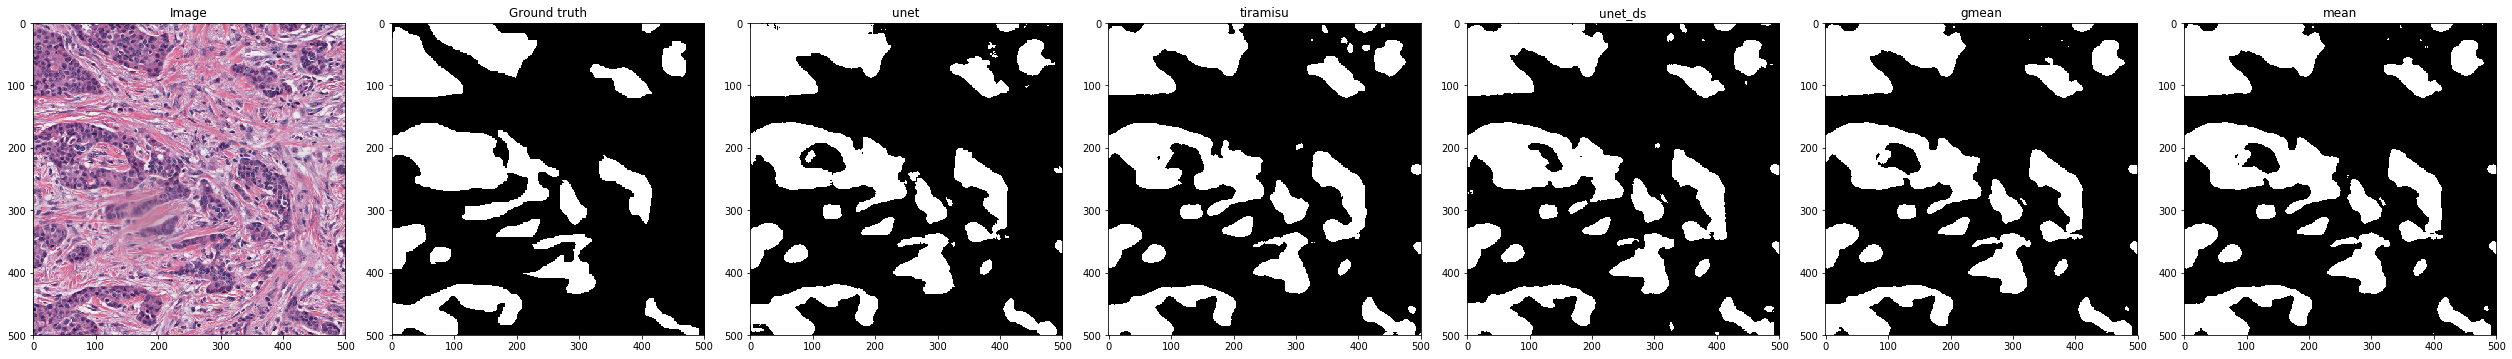

In [108]:
i = 4

fig, (ax_image, ax_groud_truth, *ax_models) = plt.subplots(1, 2 + len(models), figsize=(5 * (2 + len(models)),5))

ax_image.imshow(images[i])
ax_groud_truth.imshow(masks[i], cmap='gray')

ax_image.set_title('Image')
ax_groud_truth.set_title('Ground truth')

for ax, model, model_predictions in zip(ax_models, models, predictions_masks):
    ax.imshow(model_predictions[i], cmap='gray')
    ax.set_title(model)

fig.tight_layout()

# Get score

In [109]:
for model, model_predictions_masks in zip(models, predictions_masks):
    score = topcoder_metric(masks, model_predictions_masks)
    print(model, score)

unet 837770.780025
tiramisu 837106.434942
unet_ds 830452.497756
gmean 849227.185366
mean 847716.932006


In [129]:
threshold_data = []
for model, model_predictions in zip(models, predictions):
    for tr in np.arange(0.1, 1.0, 0.1):
        predictions_mask = np.zeros_like(model_predictions)
        predictions_mask[model_predictions>tr] = 1

        score = topcoder_metric(masks, predictions_mask)

        threshold_data.append({'model':model, 'threshold': tr, 'score': score})

In [130]:
threshold_data = pd.DataFrame(threshold_data)

In [131]:
threshold_data

,model,score,threshold
0,unet,776423.567409,0.1
1,unet,814097.825900,0.2
2,unet,831864.298586,0.3
3,unet,840450.616452,0.4
4,unet,842199.301588,0.5
5,unet,835485.313813,0.6
6,unet,817580.461536,0.7
7,unet,782654.841333,0.8
8,unet,698448.116765,0.9
9,tiramisu,770743.863668,0.1


In [132]:
threshold_data.groupby('model').score.max()

model
tiramisu    833112.089242
unet        842199.301588
unet_ds     839050.711863
Name: score, dtype: float64

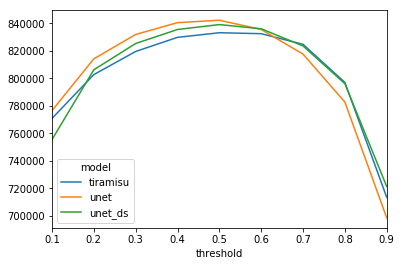

In [133]:
pd.pivot_table(threshold_data, values='score', columns='model', index='threshold').plot()

# Get scores

In [49]:
threshold = 0.3

In [50]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR
patch_size_train = 0
patch_size_predict = 0
nb_folds = 5

In [51]:
print(f'fold_number\tmodel\tuse_dice\tuse_tta\tscore')
for fold_number in range(nb_folds):
    dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)
    masks = [dataset[i][1] for i in range(len(dataset))]
    masks = np.stack(masks)

    for model in ['unet', 'tiramisu', 'unet_ds']:
        for use_tta in [True, False]:
            filename = get_prediction_filename(model, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
            _, model_predictions = load_pickle(filename)
            model_predictions_mask = np.zeros_like(model_predictions)
            model_predictions_mask[model_predictions>threshold] = 1

            score = topcoder_metric(masks, model_predictions_mask)

            print(f'{fold_number}\t{model}\t{use_dice}\t{use_tta}\t{score}')

INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 0 - 34 images


fold_number	model	use_dice	use_tta	score
0	unet	False	True	861581.9453645087
0	unet	False	False	856388.075473714
0	tiramisu	False	True	841980.7054636072
0	tiramisu	False	False	841920.7000047597
0	unet_ds	False	True	870827.7401436195


INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 1 - 34 images


0	unet_ds	False	False	868688.3125803142
1	unet	False	True	828741.1650594576
1	unet	False	False	828054.5139181466
1	tiramisu	False	True	820495.5046021653
1	tiramisu	False	False	819549.0233527272
1	unet_ds	False	True	836775.9540495817


INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 2 - 34 images


1	unet_ds	False	False	833179.513627391
2	unet	False	True	880977.4456099011
2	unet	False	False	877221.8103921716
2	tiramisu	False	True	864623.2980515661
2	tiramisu	False	False	865309.7979030601
2	unet_ds	False	True	867754.6401735075


INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 3 - 33 images


2	unet_ds	False	False	867487.3014271458
3	unet	False	True	841106.7541555531
3	unet	False	False	839104.0363780262
3	tiramisu	False	True	833891.7861838498
3	tiramisu	False	False	832344.7085590156
3	unet_ds	False	True	828269.1378720313


INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 4 - 33 images


3	unet_ds	False	False	822842.5378388849
4	unet	False	True	835410.3440418789
4	unet	False	False	831864.2985858964
4	tiramisu	False	True	820316.0105548371
4	tiramisu	False	False	819489.5746839923
4	unet_ds	False	True	832823.9518070319
4	unet_ds	False	False	825290.1901793727
